# Ocean Remote Sensing: Combining Datasets
## Marine Heat Wave Focus Continued
## EDS 220 Fall 2021

This week, we will build on the marine heat wave exercise we began last week, and expand on our Python analysis skills while becoming familiar with new sources of environmental data.

The major topics/learning objectives for this week are:
- Additional familiarity with probability distribution functions
- Interpolation of spatial data fields to a common grid
- Combining multiple datasets to gain insight into an environmental system
- Visualizing multiple datasets on a single plot (color/quiver plots)

These exercises build on the marine heat wave diagnostics discussed last week and presented in the "marineHeatWave" package developed by Eric Oliver for the Hobday et al. (2016) publication (see References) and available on Github:
https://github.com/ecjoliver/marineHeatWaves



### Datasets

Several datasets will be used during this exercise:

- SST: NOAA's 1/4° Daily Optimum Interpolation Sea Surface Temperature (OISST) version 2, or OISSTv2
- Surface currents: NCEP Global Ocean Data Assimilation System (GODAS)

### Science Goals

Last week, we learned about the importance of marine heat wave events for human and ecological systems. This week, we'll apply our new knowledge of environmental data analysis to answer more complex questions about these events:

- How does ocean circulation change during sustained marine heat waves?

### Step Zero: Configure Environment

First, load in the required packages. Note that we'll be working with daily OISSTv2 data stored in a "pickle" file, so the pickle package is included in addition to other packages from last week.

In [76]:
# Configure environment
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.stats as stats
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import pickle

### Review from Week 7: Marine Heat Wave ID, properties

The commands for extracting the Northeast Pacific portion of the OISSTv2 data from the THREDDS server are included below, but commented out since they have already been executed and stored in a file: 'oisstv2_nepac.pickle'.

In [77]:
## NOAA THREDDS server: base URL for all files 
#base_url="https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/"

## Naming convention for files: "sst.day.mean.[year].v2.nc"
yrs=range(2018,2021)
print(yrs)

In [78]:
nepac_sst=[]     # Blank variable to store output data 

for y in yrs:
    print(y)
    
    # Open the dataset into an xarray object
    mysst=xr.open_dataset("https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.anom."+str(y)+".v2.nc")
    
    # Define logical mask to be true in the Northeast Pacific (30-50N, 180-240E)
    mask_lon = (mysst.lon >= 180) & (mysst.lon <= 240)
    mask_lat = (mysst.lat >= 30) & (mysst.lat <= 50)
    # Read in data 
    nepac_sst.append(mysst.where(mask_lon & mask_lat, drop=True).squeeze())
    

In [53]:
#with open('oisstv2_nepac.pickle','wb') as f:
#    pickle.dump(nepac_sst,f)

Now we can load in the previously stored information from the pickle file with `pickle.load`:

In [79]:
# Load in NE Pacific OISSTv2 data
#with open('oisstv2_nepac.pickle','rb') as f:
#    nepac_sst=pickle.load(f)

__NOTE: I am leaving the above pickle commands in so you can see how they work; but the dataset is actually too large for Binder to handle doing the interpolation below!__

The data are stored in a list at the moment, so they need to be translated into an xarray Dataset:

In [55]:
# Concatenate list of xarray Datasets into a single Dataset, along dimension "time"
nepac_fldts=xr.concat(nepac_sst,dim='time')
nepac_fldts

# Calculate a regionally averaged time series for the NE Pacific
nepac_ts=nepac_fldts.mean('lon').mean('lat')

Now we determine the SST threshold appropriate for a marine heat wave using `np.percentile`:

In [56]:
thr=nepac_ts.reduce(np.percentile,q=90)
print(thr)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    anom     float64 1.14


and apply this as a logical mask:

In [80]:
# Mask for MHW
mhw_msk = (nepac_ts > thr)

Recall that the composite SST anomaly pattern associated with these events resembles the Northeast Pacific "blob" of 2014-16:

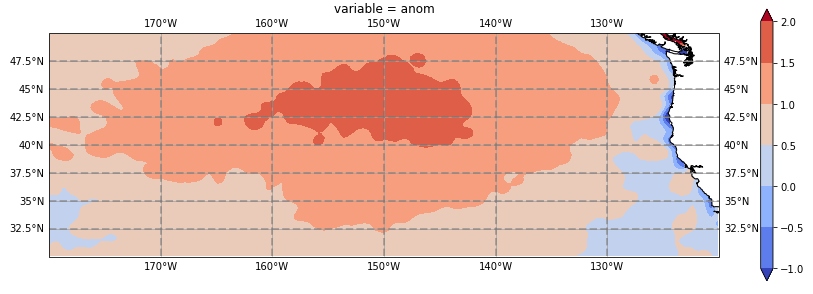

Now let's take things slightly further. Often, we care not only about the _composite_ patterns across all heat wave events, but about individual properties of those events. Some relevant examples:
- Temporal persistence: how long does a heat wave last?
- Maximum temperature: how hot does it get?
- Cumulative thermal stress: what is the "effective" combination of heat and time during the heat wave event?

To accomplish this, we must be able to identify individual marine heat wave events within a time series, and perform appropriate operations on the portion of the time series within those events. 

The `scipy` package in Python has some excellent built-in tools to identify "events" within a time series: here we'll use the `scipy.ndimage.label` functionality. This treats the input time series as an "image", which can be n-dimensional (hence the name), and "labels" parts of the input data which are considered to be connected to one another in some way. There are various options for specifying that connectivity, but here we'll just use the simplest one: a data point is connected to the preceding point if it is equal to the value at that preceding point.

Using the previously defined mask for marine heat waves, `mhw_msk`, this command identifies MHW events:

In [58]:
# Determine number of events
events, n_events = ndimage.label(mhw_msk.to_array())
n_events

16

Note that we had to convert the `mhw_msk` object to a "DataArray" first using the `to_array()` method in order for this to work correctly.

Using this set of events, we can now do things like collect all the temperature data within the events. Before we start doing that, though, let's specify an output variable to hold the information: the Python "dictionary" data type is useful here since it will allow us to store many different aspects of MHW behavior.

In [59]:
# Define empty variable to put MHW data into (type "dictionary")
mhw = {}

# Specify start, end time variables within the dataset
mhw['time_start'] = [] 
mhw['time_end'] = [] 
mhw['duration'] = [] 
mhw['dates'] = []

# Specify variables to hold MHW parameters
mhw['temp_mhw'] = []
mhw['time_peak'] = []
mhw['intensity_max'] = []
mhw['intensity_mean'] = []
mhw['intensity_cumulative'] = []
mhw['duration'] = []

Now we can go ahead and compile the relevant information into `mhw`. First, let's simply identify and store the starting and ending times associated with each MHW event, with the requirement that there is some minimum duration it must exceed in order to be considered. Here I'll use the 5-day threshold suggested by Hobday et al. (2016):

In [60]:
# Find all MHWs, collect temperature data within them into a list
minDuration=5    # set some minimum duration for the MHWs in order to count them

# Loop over set of all events
for ev in range(1,n_events+1):
    # Grab the part of the time series within the event, figure out how long it is
    event_duration = (events == ev).sum()
    # Figure out whether the event is long enough to count
    if event_duration < minDuration:
        continue
    #print('Marine heat wave length = ' + str(event_duration) + ' days')
    # If event is long enough, add data to an array
    mhw['time_start'].append(nepac_ts.time[np.where(events == ev)[1][0]])
    mhw['time_end'].append(nepac_ts.time[np.where(events == ev)[1][-1]])
    mhw['duration'].append(event_duration)

#print(mhw['time_start'][0])
#print(mhw['time_start'])

# Add number of events to MHW dictionary
mhw['n_events'] = len(mhw['time_start'])

Next, we can apply this time information to extract specific portions of the temperature time series. 

In [61]:
for ev in range(mhw['n_events']):
    # Get starting, ending point within the time series for the MHW event in question
    tt_start = np.where(nepac_ts.time==mhw['time_start'][ev])[0][0]
    tt_end = np.where(nepac_ts.time==mhw['time_end'][ev])[0][0]
    
    # Extract time series information
    temp_mhw = nepac_ts.anom[tt_start:tt_end+1]
    mhw['temp_mhw'].append(temp_mhw)
    mhw['dates'].append(nepac_ts.time[tt_start:tt_end+1])
    
    # Get peak value = date of maximum temp during MHW
    tt_peak = temp_mhw.argmax('time')
    
    # Time/date of maximum value    
    mhw['time_peak'].append(mhw['time_start'][ev] + tt_peak)
    
    # MHW Duration
    mhw['duration'].append(len(temp_mhw))
    
    # MHW intensity 
    mhw['intensity_max'].append(temp_mhw[tt_peak])
    mhw['intensity_mean'].append(temp_mhw.mean())
    mhw['intensity_cumulative'].append(temp_mhw.sum())
  

### Summarizing MHW Properties: tables, PDFs, filled line plots

OK, now let's take a deeper dive into the properties of these events. The below code selects the MHW event with the longest duration, then displays the parameters associated with that event.

Once we've put in this code, try playing around with it to return the properties of:
- the event with the largest maximum intensity
- the event with the largest cumulative intensity

In [1]:
# Find longest event

# Save dates included in event

# Print out parameters


Oftentimes, though, a more effective way to present this information is via a plot. The below code generates a line plot of the SST anomaly associated with the longest-duration MHW, and shades in the part of the time series above the MHW threshold.

In [2]:
# Create a blank figure

# Plot the SST anomaly time series

# Plot a horizontal line showing the MHW anomaly threshold

# Set the x and y limits of the plot


# Find indices for MHW of interest and shade accordingly
# index of MHW start

# index of MHW end

# Fill in parts of time series above the threshold

# Set plot axis labels etc


In [3]:
# Perform kernel density estimation on mean duration values
   # duration is a list - convert to numpy array



# Display as PDF


### Identifying marine heat wave impacts

Now that we've taken a look at the properties of MHWs themselves, let's combine this with additional data to determine the impacts of those events. 

To make things easy for ourselves, we'll use the monthly-resolution current data from the NCEP Global Ocean Data Assimilation System (GODAS), which is available on the same NOAA-hosted THREDDS server as the OISSTv2 information. This will let us visualize the differences in ocean circulation associated with the MHW!

Important things we'll need to consider:
- _Temporal resolution_. Here we'll be comparing the *daily* OISSTv2 information with the *monthly* average currents; so we'll want to pick longer-duration MHW events!
- _Spatial resolution_. To directly compare SST and currents, it's useful to *regrid* data to the same spatial resolution!

In [4]:
# NOAA THREDDS server: base URL for all files 
base_url="https://psl.noaa.gov/thredds/dodsC/Datasets/godas/"

# Naming convention for files: "ucur.[year].nc"
yrs=range(2010,2021)

Read in the GODAS current data; this uses the same syntax that we applied for OISSTv2:

In [5]:
     # Blank variable to store output data 


# Loop over years

    
    # Open the dataset into an xarray object
    
    # Define logical mask to be true in the Northeast Pacific (30-50N, 180-240E)
    # NOTE: masks the same for U and V since they're on the same grid

    # Read in data 

    

In [6]:
# Concatenate data into a single xarray Dataset for u, v velocities


Now let's take a quick look at the SST and velocity datasets. It becomes pretty obvious quickly that the coordinates are quite different between the two datasets:

In [7]:
# NE Pacific SST: OISSTv2


In [8]:
# NE Pacific zonal (east-west) current: GODAS


There are several different ways of interpolating data in Python. Here, let's use the xarray interpolation functionality: this is a wrapper to the interpolate method within scipy, so functions essentially the same way.

Here, we'll interpolate the OISSTv2 data to the GODAS grid:

In [9]:
# Interpolate SST to GODAS grid



You can easily see the difference between the two datasets by making maps:

In [10]:
# Create a blank figure

# Plot raw data


In [11]:
# Create a blank figure

# Plot interpolated data


But what we *really* want to do is to: first look at how velocity changes during a marine heat wave relative to the average ("climatology"), then make a plot of the total anomaly.

Let's get started with that, by taking our interpolated current fields and converting them to anomalies using the procedure we applied to the ERSSTv5 last week. We can apply groupby to accomplish this:

In [169]:
# Create the climatology and remove it from the current time series
# Zonal (east-west) current


# Meridional (north-south) current


Now we need to pull out the portion of the current anomaly fields that correspond to the MHW event of interest. Here, we'll use the 'longest-duration' event identified above, since that will contain multiple months of data and therefore we can get a reasonable sampling from GODAS.

In [12]:
#### Currents: GODAS
# index of MHW start
   # pick first time exceeding the MHW start time
# index of MHW end
    # pick last time below the MHW end time

#### SST: OISSTv2
# index of MHW start
   # pick first time exceeding the MHW start time
# index of MHW end
    # pick last time below the MHW end time


In [13]:
# Calculate composites over the MHW
# zonal current


# meridional current


# SST


Finally, we make a plot! Let's include both SST and current anomalies here, and plot them on the same map:
- SST in colors
- currents as vectors (arrows)

For the current information, we'll use the `quiver` method in matplotlib, which draws arrows having an x-component equal to the east-west current, and a y-component equal to the north-south current.

In [14]:
# Create an object containing the Plate-Carree map projection, centered at 180E

# Create a figure object

# Create an axis object using the specified projection

# Make a filled contour plot of the MHW SSTA using the specified map projection


# Add arrows for currents


# Set plot parameters


In the plot above, it is hard to read the arrows! There are too many of them, so Python scales them automatically to a size that's difficult to read. To get around this problem, we can plot only a subset of data. Let's do an example plotting only every third point in the current arrays:

In [15]:
# Create an object containing the Plate-Carree map projection, centered at 180E

# Create a figure object

# Create an axis object using the specified projection

# Make a filled contour plot of the MHW SSTA using the specified map projection

# Add arrows for currents

# Set plot parameters
